In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

In [3]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

Generate example data (from source notebook)

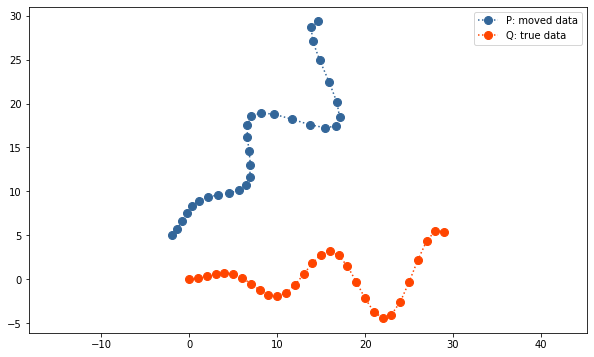

In [4]:
# initialize pertrubation rotation
angle = pi / 4
R_true = np.array([[cos(angle), -sin(angle)], 
                   [sin(angle),  cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

plot_data(moved_data, true_data, "P: moved data", "Q: true data")
plt.show()

Generate example data (hand inputted)

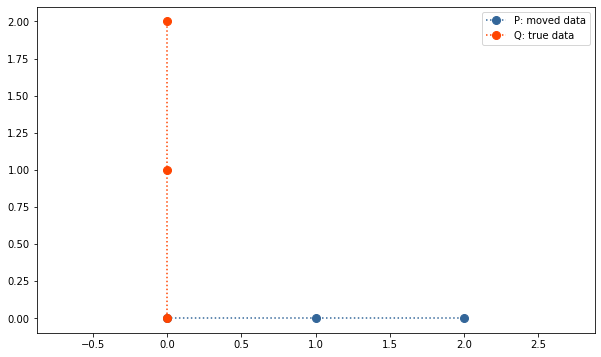

In [31]:
true_data = np.array([[0, 0, 0], [0, 1, 2]])
moved_data = np.array([[0, 1, 2], [0, 0, 0]])

Q = true_data
P = moved_data

plot_data(moved_data, true_data, "P: moved data", "Q: true data")
plt.show()

In [6]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

ICP based on SVD

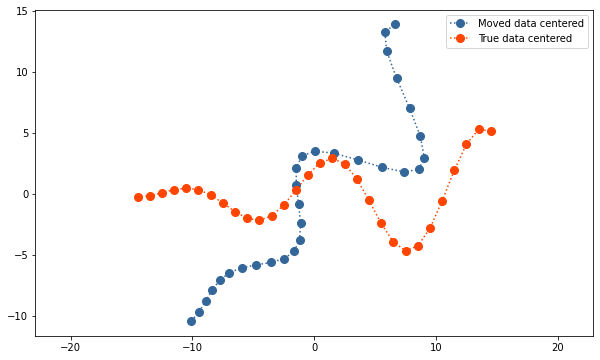

In [7]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

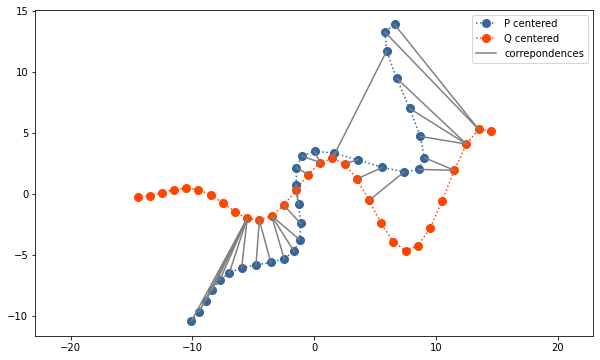

In [8]:
correspondences = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

In [9]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[1113.97274605 1153.71870122]
 [ 367.39948556  478.81890396]]


[1712.35558954   63.95608054]
R_found =
 [[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]
t_found =
 [[  0.4278782 ]
 [-10.01055887]]


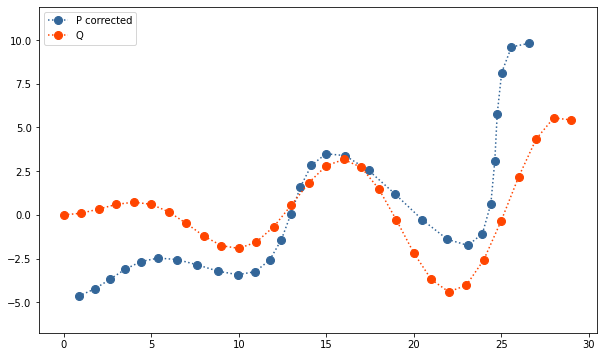

Squared diff: (P_corrected - Q) =  16.052894296516946


In [10]:
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U.dot(V_T)
t_found = center_of_Q - R_found.dot(center_of_P)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

P_corrected = R_found.dot(P) + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q')
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

# Least Squares Point-to-Point

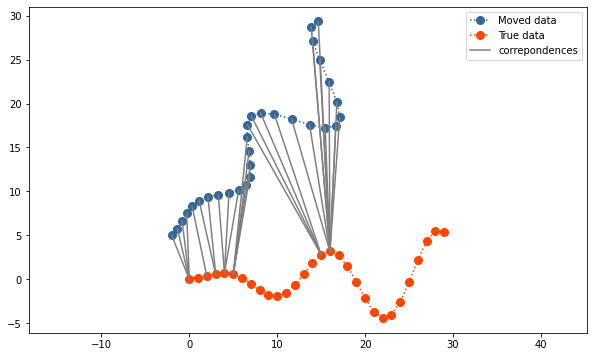

In [11]:
correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q, "Moved data", "True data")
draw_correspondeces(P, Q, correspondences, ax)
plt.show()

In [12]:
def dR(theta):
    return np.array([[-sin(theta), -cos(theta)],
                     [cos(theta),  -sin(theta)]])

def R(theta):
    return np.array([[cos(theta), -sin(theta)],
                     [sin(theta),  cos(theta)]])

In [13]:
def jacobian(x, p_point):
    theta = x[2]
    J = np.zeros((2, 3))
    J[0:2, 0:2] = np.identity(2)
    J[0:2, [2]] = dR(0).dot(p_point)
    return J

def error(x, p_point, q_point):
    rotation = R(x[2])
    translation = x[0:2]
    prediction = rotation.dot(p_point) + translation
    return prediction - q_point

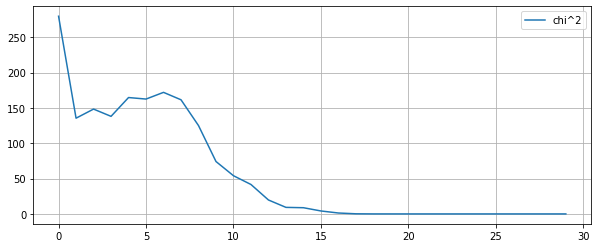

[279.8595127207586, 135.5367059198426, 148.41156916870483, 138.1360069087215, 164.76282163539946, 162.60937583974692, 172.09657147196552, 161.58393072081938, 125.08676568660157, 74.18795088775202, 54.07022667032278, 41.649044595152105, 19.71413517969009, 9.258599804821138, 8.772642882322273, 4.1720680989041625, 1.2769314893000574, 0.162803475018729, 0.014198093772484356, 0.0012239475378543383, 0.00010514834808176566, 9.024084124522558e-06, 7.742391050100685e-07, 6.642160393921599e-08, 5.698132817744802e-09, 4.888240239091062e-10, 4.193450960862397e-11, 3.597413135160727e-12, 3.0860928163708213e-13, 2.6474493804624863e-14]


In [14]:
def prepare_system(x, P, Q, correspondences, kernel=lambda distance: 1.0):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        e = error(x, p_point, q_point)
        weight = kernel(e) # Please ignore this weight until you reach the end of the notebook.
        J = jacobian(x, p_point)
        H += weight * J.T.dot(J)
        g += weight * J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_least_squares(P, Q, iterations=30, kernel=lambda distance: 1.0):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_copy, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system(x, P, Q, correspondences, kernel)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_copy = rot.dot(P.copy()) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_least_squares(P, Q)
plot_values(chi_values, label="chi^2")
print(chi_values)

In [15]:
# x = np.zeros((3,1))
# p = np.array([[1],[2]])
# q = np.array([[3],[4]])


# c = get_correspondence_indices(P, Q)

# h, g, chi = prepare_system(x, P, Q, c)
# print(h)
# print(g)
# print(chi)

In [16]:
# P_values, chi_values, corresp_values = icp_least_squares(P, Q, 1)


# for ps in P_values[-1]:
#     print(ps)
# # print(chi_values)
# # for c in corresp_values[-1]:
# #     print(c[1], end=" ")

In [17]:
# prepare_system() function testing
x = np.zeros((3,1))
c = get_correspondence_indices(P, Q)
h,g,chi = prepare_system(x,P,Q,c)

print(chi)

[[ 279.85951272 -614.57122353]
 [-614.57122353 6536.63483735]]


In [18]:
# print(get_correspondence_indices(P,Q))

for c in get_correspondence_indices(P,Q):
    print(c[1], end=" ")

0 0 0 0 2 3 3 4 4 4 5 5 5 5 5 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 

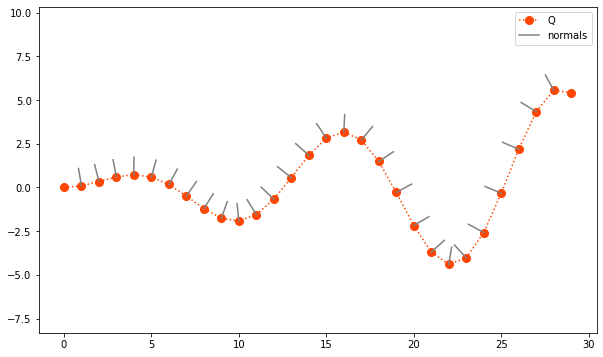

In [19]:
def compute_normals(points, step=1):
    normals = [np.array([[0, 0]])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        dx = next_point[0] - prev_point[0] 
        dy = next_point[1] - prev_point[1]
        normal = np.array([[0, 0],[-dy, dx]])
        normal = normal / np.linalg.norm(normal)
        normals.append(normal[[1], :])  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([[0, 0]]))
    return normals, normals_at_points

def plot_normals(normals, ax):
    label_added = False
    for normal in normals:
        if not label_added:
            ax.plot(normal[:,0], normal[:,1], color='grey', label='normals')
            label_added = True
        else:
            ax.plot(normal[:,0], normal[:,1], color='grey')
    ax.legend()
    return ax

Q_normals, Q_normals_to_draw = compute_normals(Q)
ax = plot_data(None, Q, None, 'Q')
ax = plot_normals(Q_normals_to_draw, ax)
plt.show()

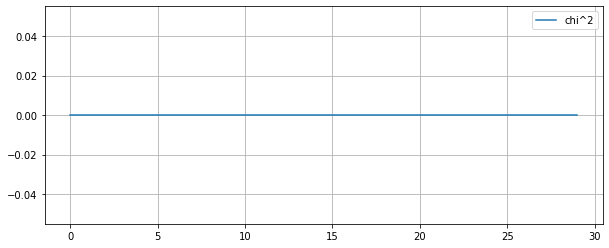

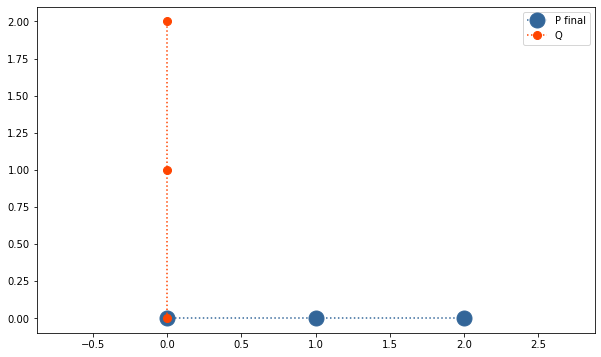

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [34]:
def prepare_system_normals(x, P, Q, correspondences, Q_normals):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    # print(Q_normals)
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        normal = Q_normals[j]
        e = normal.dot(error(x, p_point, q_point))
        J = normal.dot(jacobian(x, p_point))
        H += J.T.dot(J)
        g += J.T.dot(e)
        chi += e.T * e
        # print(e)
        # print(j)
        # print(normal)
    return H, g, chi

def icp_normal(P, Q, Q_normals, iterations=20):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_latest = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_latest, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system_normals(x, P, Q, correspondences, Q_normals)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        chi_values.append(chi.item(0)) # add error to list of errors
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_latest = rot.dot(P.copy()) + t
        P_values.append(P_latest)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_normal(P, Q, Q_normals, iterations=30)
plot_values(chi_values, label="chi^2")

ax = plot_data(P_values[1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()

print(chi_values)

In [21]:
# print(compute_normals(Q)[0])

corresp = get_correspondence_indices(P, Q)
(normals, normals_to_draw) = compute_normals(Q)

(h, g, chi) = prepare_system_normals(x, P, Q, corresp, normals)
# print(h)

In [22]:
print(P_values[-1])

[[-1.33226763e-15  1.00000000e+00  2.00000000e+00  3.00000000e+00
   4.00000000e+00  5.00000000e+00  6.00000000e+00  7.00000000e+00
   8.00000000e+00  9.00000000e+00  1.00000000e+01  1.10000000e+01
   1.20000000e+01  1.30000000e+01  1.40000000e+01  1.50000000e+01
   1.60000000e+01  1.70000000e+01  1.80000000e+01  1.90000000e+01
   2.00000000e+01  2.10000000e+01  2.20000000e+01  2.30000000e+01
   2.40000000e+01  2.50000000e+01  2.60000000e+01  2.70000000e+01
   2.80000000e+01  2.90000000e+01]
 [-8.88178420e-16  9.58851077e-02  3.36588394e-01  5.98496992e-01
   7.27437941e-01  5.98472144e-01  1.69344010e-01 -4.91096519e-01
  -1.21088399e+00 -1.75955421e+00 -1.91784855e+00 -1.55218872e+00
  -6.70597196e-01  5.59311969e-01  1.83956248e+00  2.81399993e+00
   3.16594639e+00  2.71485618e+00  1.48362655e+00 -2.85574258e-01
  -2.17608444e+00 -3.69472219e+00 -4.39995691e+00 -4.02708000e+00
  -2.57555001e+00 -3.31609487e-01  2.18486859e+00  4.34043590e+00
   5.54740119e+00  5.42239132e+00]]


In [23]:
print(Q)

[[ 0.          1.          2.          3.          4.          5.
   6.          7.          8.          9.         10.         11.
  12.         13.         14.         15.         16.         17.
  18.         19.         20.         21.         22.         23.
  24.         25.         26.         27.         28.         29.        ]
 [ 0.          0.09588511  0.33658839  0.59849699  0.72743794  0.59847214
   0.16934401 -0.49109652 -1.21088399 -1.75955421 -1.91784855 -1.55218872
  -0.6705972   0.55931197  1.83956248  2.81399993  3.16594639  2.71485618
   1.48362655 -0.28557426 -2.17608444 -3.69472219 -4.39995691 -4.02708
  -2.57555001 -0.33160949  2.18486859  4.3404359   5.54740119  5.42239132]]


In [ ]:
test